In [1]:
from __future__ import annotations

from collections import defaultdict
from typing import Dict, Iterable, List, Tuple, Any, Optional, Set


Edge = Tuple[Any, Any, float]  # (src, dst, similarity)

# Functional-Graph Star Decomposition  
### Anchor-Based Clustering in Outdegree-1 Similarity Graphs

---

## 1. Problem Setting

Let the graph be

$$
G = (V, E, w)
$$

where:

- $V$ is a finite set of nodes  
- $E \subseteq V \times V$ is a set of directed edges  
- $w : E \rightarrow \mathbb{R}_{\ge 0}$ assigns a similarity score to each edge  

The graph is **functional**, meaning:

$$
\forall u \in V,\quad \deg^+(u) \le 1
$$

Each node points to **at most one** nearest neighbor.

An edge $(u \rightarrow v)$ with weight $w(u,v)$ encodes:

> “Node $v$ is the closest neighbor of $u$ with similarity $w(u,v)$.”

---

## 2. Structure of Functional Graphs

Define the successor function:

$$
f(u) =
\begin{cases}
v & \text{if } (u \rightarrow v) \in E \\
\bot & \text{if } u \text{ has no outgoing edge}
\end{cases}
$$

Repeated application of $f$ generates a trajectory:

$$
u,\ f(u),\ f^2(u),\ \dots
$$

Since $V$ is finite, every trajectory terminates in exactly one of the following:

### Sink
A node $s$ such that:

$$
f(s) = \bot
$$

### Cycle
A set of nodes $C = \{c_1, \dots, c_k\}$ such that:

$$
f(c_i) = c_{i+1}, \quad f(c_k) = c_1
$$

Thus, each connected component consists of inward-pointing trees rooted at a sink or a cycle.

---

## 3. Objective

We aim to decompose $G$ into **disjoint depth-1 star clusters** of the form:

$$
\{\, c \mapsto \{(u_i, s_i)\} \,\}
$$

where:

- $c$ is an **anchor** (cluster center)
- each $u_i \neq c$ is assigned to exactly one anchor
- $s_i$ is the similarity between $u_i$ and $c$
- no node appears in more than one cluster

This yields a partition:

$$
V = \bigsqcup_{c \in \mathcal{A}} \left( \{c\} \cup \{u : \text{anchor}(u)=c\} \right)
$$

---

## 4. Anchor Selection

### Sink Anchors

If $s$ is a sink, it becomes its own anchor:

$$
\text{anchor}(s) = s
$$

### Cycle Anchors

For a cycle $C$, choose a representative anchor:

$$
\text{anchor}(C)
=
\arg\max_{c \in C}
\sum_{(u \rightarrow c) \in E} w(u,c)
$$

This selects the most globally attractive node in the cycle.

---

## 5. Anchor Assignment

Each node is assigned recursively:

$$
\text{anchor}(u) =
\begin{cases}
u & \text{if } u \text{ is an anchor} \\
\text{anchor}(f(u)) & \text{otherwise}
\end{cases}
$$

Because the graph is functional, this assignment is unique.

---

## 6. Similarity Aggregation

Let the unique path from $u$ to its anchor $c$ be:

$$
u = v_0 \rightarrow v_1 \rightarrow \cdots \rightarrow v_k = c
$$

with edge similarities $w(v_i, v_{i+1})$.

We define **node-to-anchor similarity** using bottleneck aggregation:

$$
\mathrm{sim}(u,c)
=
\min_{0 \le i < k} w(v_i, v_{i+1})
$$

For anchors themselves:

$$
\mathrm{sim}(c,c) = 1
$$

---

## 7. Star Construction

For each anchor $c$, define its cluster:

$$
\mathcal{C}(c)
=
\left\{
(u, \mathrm{sim}(u,c))
\;\middle|\;
u \in V,\ u \neq c,\ \text{anchor}(u) = c
\right\}
$$

The final output is:

$$
\{\, c \mapsto \mathcal{C}(c) \,\}
$$

Each cluster is a **depth-1 star**, and clusters are **node-disjoint**.

---

## 8. Properties

- Time complexity: $O(|V|)$  
- Space complexity: $O(|V|)$  
- Deterministic  
- Handles chains, sinks, cycles  
- Produces flat, interpretable clusters  

---

## 9. Intuition

Each node “votes” for its nearest neighbor.  
Votes propagate until reaching a stable consensus point.  

Sinks and strong cycle nodes act as **anchors**, defining attraction basins in the graph.


In [ ]:
def decompose_into_depth1_clusters(
    edges: Iterable[Edge],
    *,
    nodes: Optional[Iterable[Any]] = None,
    combine: str = "min",               # "min" or "product"
    cycle_anchor: str = "max_in_sum",   # "max_in_sum" or "min_id"
) -> Dict[Any, List[List[Any]]]:
    """
    Functional digraph clustering (outdegree <= 1).

    Each node follows its outgoing edge (if any) until:
      - a sink (outdegree 0), or
      - a directed cycle.

    Each sink/cycle becomes a "terminal component". We pick an "anchor" for each:
      - sink: itself
      - cycle: chosen by `cycle_anchor`

    Every node is assigned to exactly one anchor; output is a star (depth-1) cluster:
        { anchor: [[member, sim(member, anchor)], ...], ... }
    Anchors always appear as keys; a pure anchor has [].

    Similarity-to-anchor is aggregated along the path using:
      - combine="min": bottleneck similarity along the path (maximin-ish)
      - combine="product": multiplicative decay along the path

    Notes:
      - If a node is an anchor itself, it is NOT listed as a member of its own list.
      - Assumes similarity weights are floats; no normalization enforced.
    """

    # ----------------------------
    # Build next pointers + weights
    # ----------------------------
    next_of: Dict[Any, Any] = {}
    w_of: Dict[Any, float] = {}
    all_nodes: Set[Any] = set(nodes) if nodes is not None else set()

    for u, v, w in edges:
        all_nodes.add(u)
        all_nodes.add(v)
        if u in next_of:
            raise ValueError(f"Outdegree > 1 detected for node {u!r}: "
                             f"already has {next_of[u]!r}, new edge to {v!r}")
        next_of[u] = v
        w_of[u] = float(w)

    # include isolated nodes (if nodes provided)
    # otherwise only nodes seen in edges are clustered

    # -----------------------------------
    # Incoming sums (helpful for anchoring)
    # -----------------------------------
    incoming_sum = defaultdict(float)
    for u, v, w in edges:
        incoming_sum[v] += float(w)

    # -----------------------------------
    # 1) Detect cycles (functional graph)
    # -----------------------------------
    UNVIS, VISITING, DONE = 0, 1, 2
    state: Dict[Any, int] = {n: UNVIS for n in all_nodes}
    cycle_id_of: Dict[Any, int] = {}          # node -> cycle_id
    cycles: List[List[Any]] = []              # list of cycle node lists

    def extract_cycle(start: Any) -> List[Any]:
        # start is a node already in current path (VISITING).
        cyc = [start]
        cur = next_of[start]
        while cur != start:
            cyc.append(cur)
            cur = next_of[cur]
        return cyc

    for n in list(all_nodes):
        if state[n] != UNVIS:
            continue
        cur = n
        path_index: Dict[Any, int] = {}
        stack: List[Any] = []

        while True:
            if cur not in state:
                # in case nodes was None and we encounter something weird; keep safe
                state[cur] = UNVIS

            if state[cur] == DONE:
                break

            if state[cur] == VISITING:
                # found a cycle: cur is in current stack
                cyc = extract_cycle(cur)
                cid = len(cycles)
                cycles.append(cyc)
                for x in cyc:
                    cycle_id_of[x] = cid
                break

            # mark visiting, push
            state[cur] = VISITING
            path_index[cur] = len(stack)
            stack.append(cur)

            # step
            if cur not in next_of:
                break
            cur = next_of[cur]

        # mark the traversed stack done
        for x in stack:
            state[x] = DONE

    # -----------------------------------
    # 2) Pick an anchor per terminal component
    # -----------------------------------
    # For sinks (outdegree 0), anchor is itself (handled later).
    # For cycles, choose one node as representative anchor.
    cycle_anchor_of: Dict[int, Any] = {}

    for cid, cyc in enumerate(cycles):
        if cycle_anchor == "min_id":
            # works well if nodes are comparable (strings, ints)
            anchor = min(cyc)
        elif cycle_anchor == "max_in_sum":
            # pick node with largest total incoming similarity (global incoming sum)
            # tie-breaker: min(cyc) for stability if comparable
            best = None
            best_key = None
            for x in cyc:
                key = (incoming_sum.get(x, 0.0),)  # primary
                # stable tie-breaker if possible
                try:
                    key = (incoming_sum.get(x, 0.0), -0.0)  # placeholder
                except Exception:
                    pass
                if best is None:
                    best = x
                    best_key = incoming_sum.get(x, 0.0)
                else:
                    if incoming_sum.get(x, 0.0) > best_key:
                        best = x
                        best_key = incoming_sum.get(x, 0.0)
                    elif incoming_sum.get(x, 0.0) == best_key:
                        # tie-break (try min id if comparable)
                        try:
                            if x < best:
                                best = x
                        except Exception:
                            pass
            anchor = best
        else:
            raise ValueError("cycle_anchor must be 'max_in_sum' or 'min_id'")

        cycle_anchor_of[cid] = anchor

    # -----------------------------------
    # 3) Assign each node -> anchor + sim_to_anchor (memoized)
    # -----------------------------------
    anchor_of: Dict[Any, Any] = {}
    sim_to_anchor: Dict[Any, float] = {}

    def comb(a: float, b: float) -> float:
        if combine == "min":
            return a if a < b else b
        if combine == "product":
            return a * b
        raise ValueError("combine must be 'min' or 'product'")

    def resolve(node: Any) -> Tuple[Any, float]:
        """
        Returns (anchor, sim(node->anchor)).
        Anchors have sim = 1.0 for themselves.
        """
        if node in anchor_of:
            return anchor_of[node], sim_to_anchor[node]

        # If node is in a cycle, its anchor is the chosen cycle representative.
        if node in cycle_id_of:
            cid = cycle_id_of[node]
            a = cycle_anchor_of[cid]
            if node == a:
                anchor_of[node] = a
                sim_to_anchor[node] = 1.0
                return a, 1.0

            # Similarity from node to anchor in the same cycle: follow next pointers
            # until reaching anchor and aggregate weights.
            cur = node
            s = 1.0
            while cur != a:
                w = w_of[cur]
                s = comb(w, s) if combine == "min" else (s * w)
                cur = next_of[cur]
            anchor_of[node] = a
            sim_to_anchor[node] = s
            return a, s

        # Sink => anchor is itself
        if node not in next_of:
            anchor_of[node] = node
            sim_to_anchor[node] = 1.0
            return node, 1.0

        # Otherwise, follow to next
        nxt = next_of[node]
        a_nxt, s_nxt = resolve(nxt)
        w = w_of[node]
        s = comb(w, s_nxt) if combine == "min" else (w * s_nxt)
        anchor_of[node] = a_nxt
        sim_to_anchor[node] = s
        return a_nxt, s

    for n in all_nodes:
        resolve(n)

    # -----------------------------------
    # 4) Build depth-1 clusters (stars), no repeated nodes
    # -----------------------------------
    clusters: Dict[Any, List[List[Any]]] = {a: [] for a in set(anchor_of.values())}

    for n in all_nodes:
        a = anchor_of[n]
        if n == a:
            continue
        clusters[a].append([n, sim_to_anchor[n]])

    # Optional: deterministic ordering (higher similarity first)
    for a, members in clusters.items():
        members.sort(key=lambda x: x[1], reverse=True)

    return clusters

In [7]:
import matplotlib.pyplot as plt
import networkx as nx


def plot_similarity_graph(edges):
    """
    Plot a directed weighted graph where edge weights represent similarity.
    
    Args:
        edges: list of (src, dst, weight)
    """
    G = nx.DiGraph()

    # add edges
    for u, v, w in edges:
        G.add_edge(u, v, weight=w)

    # layout (spring works well for small graphs)
    pos = nx.spring_layout(G, seed=42)

    plt.figure(figsize=(8, 6))

    # draw nodes
    nx.draw_networkx_nodes(
        G, pos,
        node_size=1200,
        node_color="#E6F2FF",
        edgecolors="black"
    )

    # draw edges with arrows
    nx.draw_networkx_edges(
        G, pos,
        arrowstyle="->",
        arrowsize=18,
        width=2
    )

    # draw node labels
    nx.draw_networkx_labels(
        G, pos,
        font_size=11,
        font_weight="bold"
    )

    # edge labels (similarities)
    edge_labels = {
        (u, v): f"{d['weight']:.2f}"
        for u, v, d in G.edges(data=True)
    }

    nx.draw_networkx_edge_labels(
        G, pos,
        edge_labels=edge_labels,
        font_size=10
    )

    plt.title("Directed Similarity Graph (Outdegree ≤ 1)", fontsize=14)
    plt.axis("off")
    plt.show()

In [5]:
edges = [
    ("1", "2", 0.85),
    ("2", "3", 0.90),
    ("3", "2", 0.90),
    ("4", "2", 0.80),
    ("5", "3", 0.85),
    ("6", "3", 0.80),
    ("7", "1", 0.80)
]
nodes = ["1", "2", "3", "4", "5", "6", "7", "8"]

print(decompose_into_depth1_clusters(edges, nodes=nodes, combine="min"))

{'8': [], '2': [['3', 0.9], ['5', 0.85], ['1', 0.85], ['6', 0.8], ['7', 0.8], ['4', 0.8]]}


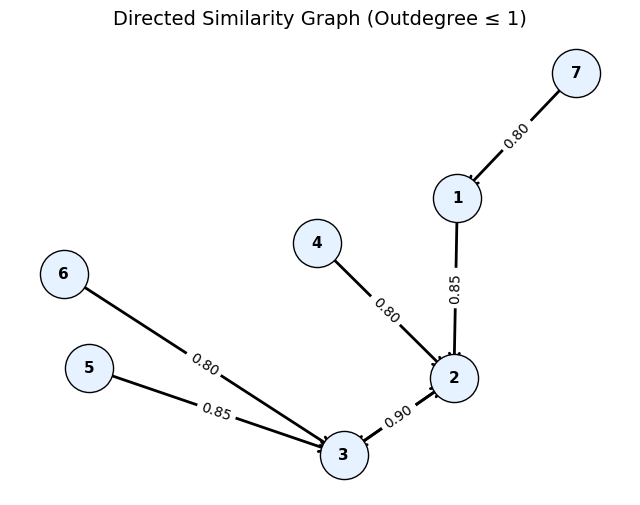

In [8]:
plot_similarity_graph(edges)